# Using linear regression to determine wine quality

## Import data and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
# import white_wine dataset
white_wine = pd.read_csv('winequality-white.csv')

## Inspect and clean data

In [3]:
# inspect data
white_wine.head()

,"fixed acidity;""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
0,7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6
1,6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9...
2,8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;1...
3,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...
4,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...


Inspecting the data reveals that the data was imported as one column, with each value separated by a semi-colon. I split the data on each semi-colon to get a proper dataframe. Then, I renamed the columns using my preferred naming convention (replace spaces with underscores).

In [4]:
# all data is in one column; split data on ';'
white_wine = white_wine['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'].str.split(";",expand=True)

In [5]:
# rename columns
white_wine = white_wine.rename(columns={
    0: "fixed_acidity", 
    1: 'volatile_acidity',
    2: 'citric_acid',
    3: 'residual_sugar',
    4: 'chlorides',
    5: 'free_sulfur_dioxide',
    6: 'total_sulfur_dioxide',
    7: 'density',
    8: 'pH',
    9: 'sulphates',
    10: 'alcohol',
    11: 'quality'
    })

Now that the data is structured appropriately, I drop duplicates and change the data types from object to either numeric types (float or int). Dropping duplicates results in 3961 values per column, compared to 4897 values per column with duplicates included; almost 25% of observations are duplicates.

In [6]:
# inspect data
white_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fixed_acidity         4898 non-null   object
 1   volatile_acidity      4898 non-null   object
 2   citric_acid           4898 non-null   object
 3   residual_sugar        4898 non-null   object
 4   chlorides             4898 non-null   object
 5   free_sulfur_dioxide   4898 non-null   object
 6   total_sulfur_dioxide  4898 non-null   object
 7   density               4898 non-null   object
 8   pH                    4898 non-null   object
 9   sulphates             4898 non-null   object
 10  alcohol               4898 non-null   object
 11  quality               4898 non-null   object
dtypes: object(12)
memory usage: 459.3+ KB


In [7]:
# drop duplicates
white_wine = white_wine.drop_duplicates()

In [8]:
# change dtypes from object to float
white_wine = white_wine.apply(pd.to_numeric)

Next, I view the summary statistics to look for any unusual patterns in the data that may affect the model. Several variables have maximum values that are significantly higher than their 75th percentile value, indicating that outliers are skewing the data. Viewing the skew of each variable affirms this assumption.

In [9]:
# view summary statistics
white_wine.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,6.839346,0.280538,0.334332,5.914819,0.045905,34.889169,137.193512,0.993790,3.195458,0.490351,10.589358,5.854835
std,0.866860,0.103437,0.122446,4.861646,0.023103,17.210021,43.129065,0.002905,0.151546,0.113523,1.217076,0.890683
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,106.000000,0.991620,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993500,3.180000,0.480000,10.400000,6.000000
75%,7.300000,0.330000,0.390000,8.900000,0.050000,45.000000,166.000000,0.995710,3.290000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [10]:
# show skew of data before outliers are removed
white_wine.skew(axis = 0, skipna = True)

# all variables have a right skew; some more extreme than others

fixed_acidity           0.696100
volatile_acidity        1.641081
citric_acid             1.310601
residual_sugar          1.333639
chlorides               4.969076
free_sulfur_dioxide     1.566680
total_sulfur_dioxide    0.456800
density                 1.273318
pH                      0.455457
sulphates               0.937853
alcohol                 0.450697
quality                 0.112004
dtype: float64

## Remove Outliers

I removed outliers using the IQR method. This method replaces any value that is outside of the defined range (quartile 1 - 1.5 * IQR, to quartile 3 + 1.5 * IQR) with either the maximum or minimum value of the range. Outliers are removed for all dependent variables ('quality' is the independent variable).

In [11]:
# remove outliers using iqr method

# define white_wine_trimmed_iqr df to hold trimmed variables
white_wine_trimmed_iqr = white_wine.copy(deep = True)

# define columns to be trimmed
white_wine_iv = white_wine[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]

# replace outliers with upper whisker / lower whisker value
for column in white_wine_iv:
    q1 = white_wine_trimmed_iqr[column].quantile(0.25)
    q3 = white_wine_trimmed_iqr[column].quantile(0.75)
    iqr = q3 - q1
    upper_whisker = q3 + (iqr*1.5)
    lower_whisker = q1 - (iqr*1.5)
    white_wine_trimmed_iqr.loc[white_wine_trimmed_iqr[column] > upper_whisker, column] = upper_whisker
    white_wine_trimmed_iqr.loc[white_wine_trimmed_iqr[column] < lower_whisker, column] = lower_whisker

Viewing the summary statistics and skew after removing outliers shows that the most extreme values have been removed, and the skew values are reduced.

In [12]:
# examine summary statistics
white_wine_trimmed_iqr.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,6.826319,0.276776,0.330323,5.895355,0.043406,34.644156,137.034966,0.993777,3.194466,0.488346,10.589358,5.854835
std,0.817914,0.090451,0.103951,4.744215,0.011608,16.026802,42.479459,0.002806,0.148246,0.107221,1.217076,0.890683
min,4.800000,0.080000,0.090000,0.600000,0.012500,2.000000,16.000000,0.987110,2.790000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,106.000000,0.991620,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993500,3.180000,0.480000,10.400000,6.000000
75%,7.300000,0.330000,0.390000,8.900000,0.050000,45.000000,166.000000,0.995710,3.290000,0.550000,11.400000,6.000000
max,8.800000,0.510000,0.570000,19.850000,0.072500,78.000000,256.000000,1.001845,3.590000,0.760000,14.200000,9.000000


In [13]:
# show skew of data after outliers are removed
white_wine_trimmed_iqr.skew(axis = 0, skipna = True)

# all variables have a right skew, but the skew of each variable is less extreme when outliers are removed

fixed_acidity           0.298077
volatile_acidity        0.726487
citric_acid             0.334512
residual_sugar          0.877875
chlorides               0.529335
free_sulfur_dioxide     0.429342
total_sulfur_dioxide    0.297051
density                 0.324569
pH                      0.304509
sulphates               0.564707
alcohol                 0.450697
quality                 0.112004
dtype: float64

## Explore data

Next, I examine the distribution of each independent variable through histograms. I compare the distribution of the variables in the original dataset with the distribution after variables have been removed.<br><br>
The histograms reveal that after the outliers are removed using the IQR method, several of the independent variables now have a spike at the max value. Fixed Acidity, Volatile Acidity, Citric Acid, Chlorides, Free Sulfur Dioxide, pH each have spikes at the max value.

Text(0.5, 1.0, 'without outliers')

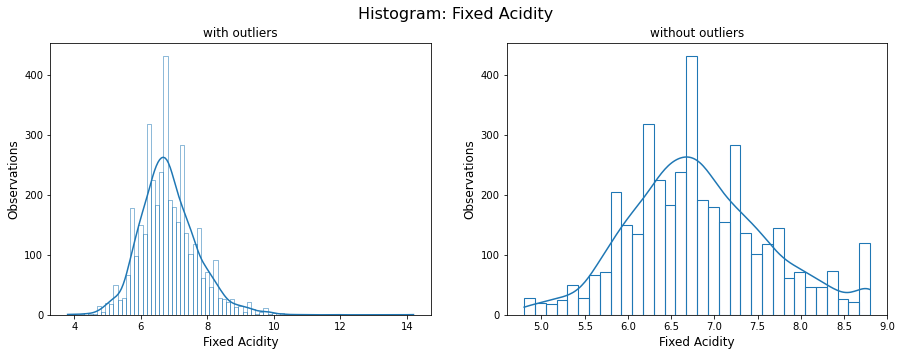

In [14]:
# histograms comparing fixed acidity with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogram: Fixed Acidity', fontsize=16)

sns.histplot(ax=axes[0], data= white_wine, x="fixed_acidity", kde=True, fill=False)
axes[0].set_xlabel('Fixed Acidity', fontsize=12)
axes[0].set_ylabel('Observations', fontsize=12)
axes[0].set_title('with outliers')

sns.histplot(ax=axes[1], data= white_wine_trimmed_iqr, x="fixed_acidity", kde=True, fill=False)
axes[1].set_xlabel('Fixed Acidity', fontsize=12)
axes[1].set_ylabel('Observations', fontsize=12)
axes[1].set_title('without outliers')

Text(0.5, 1.0, 'without outliers')

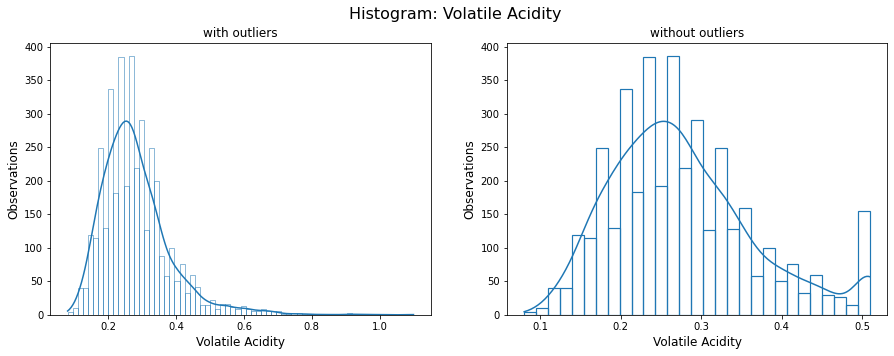

In [15]:
# histograms comparing volatile acidity with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogram: Volatile Acidity', fontsize=16)

sns.histplot(ax=axes[0], data=white_wine, x="volatile_acidity", kde=True, fill=False)
axes[0].set_xlabel('Volatile Acidity', fontsize=12)
axes[0].set_ylabel('Observations', fontsize=12)
axes[0].set_title('with outliers')

sns.histplot(ax=axes[1], data=white_wine_trimmed_iqr, x="volatile_acidity", kde=True, fill=False)
axes[1].set_xlabel('Volatile Acidity', fontsize=12)
axes[1].set_ylabel('Observations', fontsize=12)
axes[1].set_title('without outliers')

Text(0.5, 1.0, 'without outliers')

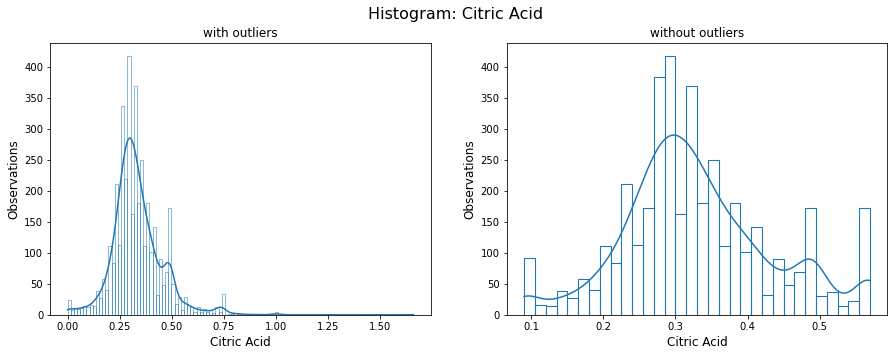

In [16]:
# histograms comparing citric acid with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogram: Citric Acid', fontsize=16)

sns.histplot(ax=axes[0], data=white_wine, x="citric_acid", kde=True, fill=False)
axes[0].set_xlabel('Citric Acid', fontsize=12)
axes[0].set_ylabel('Observations', fontsize=12)
axes[0].set_title('with outliers')

sns.histplot(ax=axes[1], data=white_wine_trimmed_iqr, x="citric_acid", kde=True, fill=False)
axes[1].set_xlabel('Citric Acid', fontsize=12)
axes[1].set_ylabel('Observations', fontsize=12)
axes[1].set_title('without outliers')

Text(0.5, 1.0, 'without outliers')

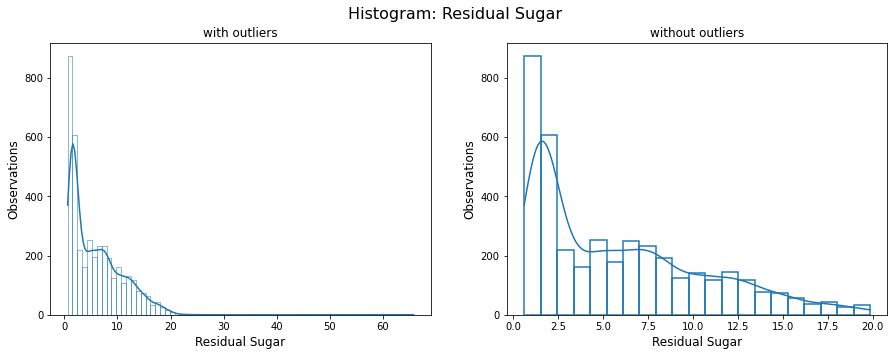

In [17]:
# histograms comparing citric acid with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogram: Residual Sugar', fontsize=16)

sns.histplot(ax=axes[0], data=white_wine, x="residual_sugar", kde=True, fill=False)
axes[0].set_xlabel('Residual Sugar', fontsize=12)
axes[0].set_ylabel('Observations', fontsize=12)
axes[0].set_title('with outliers')

sns.histplot(ax=axes[1], data=white_wine_trimmed_iqr, x="residual_sugar", kde=True, fill=False)
axes[1].set_xlabel('Residual Sugar', fontsize=12)
axes[1].set_ylabel('Observations', fontsize=12)
axes[1].set_title('without outliers')

Text(0.5, 1.0, 'without outliers')

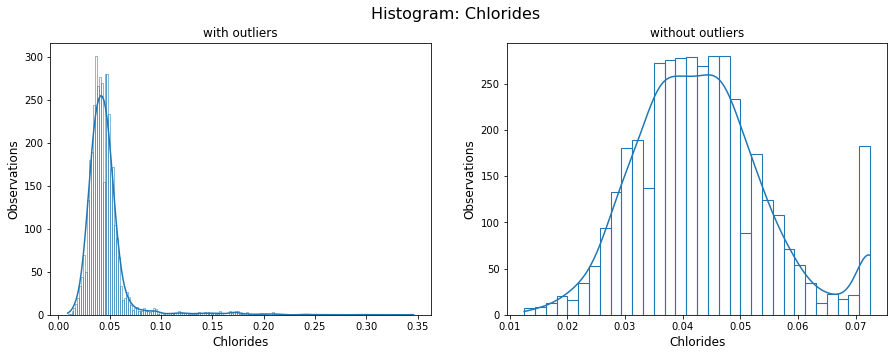

In [18]:
# histograms comparing citric acid with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogram: Chlorides', fontsize=16)

sns.histplot(ax=axes[0], data=white_wine, x="chlorides", kde=True, fill=False)
axes[0].set_xlabel('Chlorides', fontsize=12)
axes[0].set_ylabel('Observations', fontsize=12)
axes[0].set_title('with outliers')

sns.histplot(ax=axes[1], data=white_wine_trimmed_iqr, x="chlorides", kde=True, fill=False)
axes[1].set_xlabel('Chlorides', fontsize=12)
axes[1].set_ylabel('Observations', fontsize=12)
axes[1].set_title('without outliers')

Text(0.5, 1.0, 'without outliers')

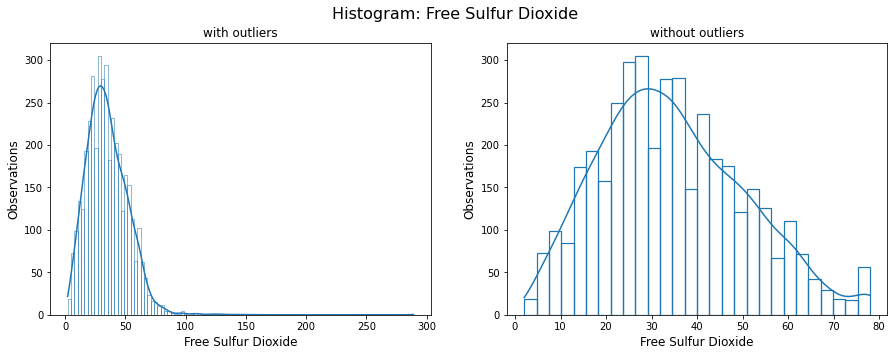

In [19]:
# histograms comparing citric acid with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogram: Free Sulfur Dioxide', fontsize=16)

sns.histplot(ax=axes[0], data=white_wine, x="free_sulfur_dioxide", kde=True, fill=False)
axes[0].set_xlabel('Free Sulfur Dioxide', fontsize=12)
axes[0].set_ylabel('Observations', fontsize=12)
axes[0].set_title('with outliers')

sns.histplot(ax=axes[1], data=white_wine_trimmed_iqr, x="free_sulfur_dioxide", kde=True, fill=False)
axes[1].set_xlabel('Free Sulfur Dioxide', fontsize=12)
axes[1].set_ylabel('Observations', fontsize=12)
axes[1].set_title('without outliers')

Text(0.5, 1.0, 'without outliers')

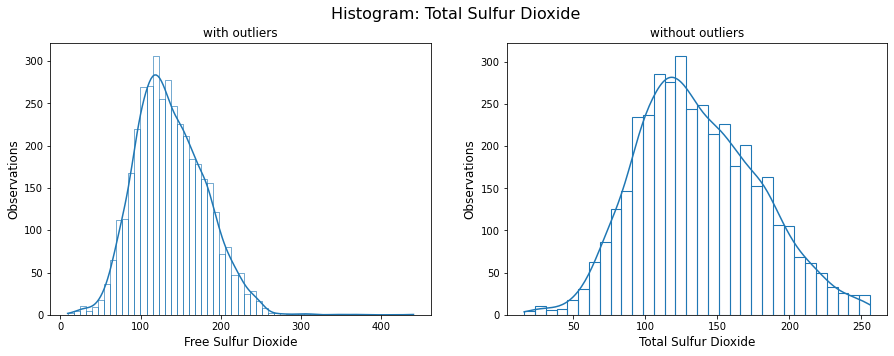

In [20]:
# histograms comparing citric acid with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogram: Total Sulfur Dioxide', fontsize=16)

sns.histplot(ax=axes[0], data=white_wine, x="total_sulfur_dioxide", kde=True, fill=False)
axes[0].set_xlabel('Free Sulfur Dioxide', fontsize=12)
axes[0].set_ylabel('Observations', fontsize=12)
axes[0].set_title('with outliers')

sns.histplot(ax=axes[1], data=white_wine_trimmed_iqr, x="total_sulfur_dioxide", kde=True, fill=False)
axes[1].set_xlabel('Total Sulfur Dioxide', fontsize=12)
axes[1].set_ylabel('Observations', fontsize=12)
axes[1].set_title('without outliers')

Text(0.5, 1.0, 'without outliers')

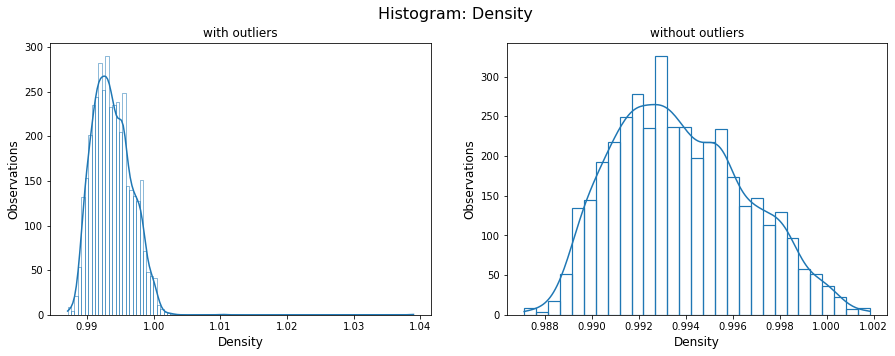

In [21]:
# histograms comparing citric acid with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogram: Density', fontsize=16)

sns.histplot(ax=axes[0], data=white_wine, x="density", kde=True, fill=False)
axes[0].set_xlabel('Density', fontsize=12)
axes[0].set_ylabel('Observations', fontsize=12)
axes[0].set_title('with outliers')

sns.histplot(ax=axes[1], data=white_wine_trimmed_iqr, x="density", kde=True, fill=False)
axes[1].set_xlabel('Density', fontsize=12)
axes[1].set_ylabel('Observations', fontsize=12)
axes[1].set_title('without outliers')

Text(0.5, 1.0, 'without outliers')

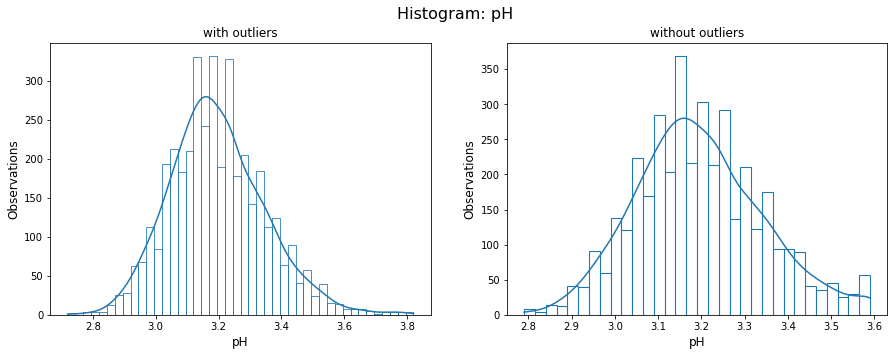

In [22]:
# histograms comparing citric acid with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogram: pH', fontsize=16)

sns.histplot(ax=axes[0], data=white_wine, x="pH", kde=True, fill=False)
axes[0].set_xlabel('pH', fontsize=12)
axes[0].set_ylabel('Observations', fontsize=12)
axes[0].set_title('with outliers')

sns.histplot(ax=axes[1], data=white_wine_trimmed_iqr, x="pH", kde=True, fill=False)
axes[1].set_xlabel('pH', fontsize=12)
axes[1].set_ylabel('Observations', fontsize=12)
axes[1].set_title('without outliers')

Text(0.5, 1.0, 'without outliers')

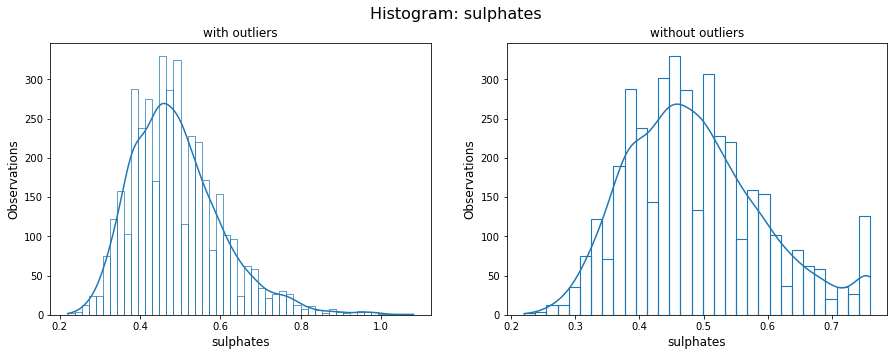

In [23]:
# histograms comparing citric acid with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogram: sulphates', fontsize=16)

sns.histplot(ax=axes[0], data=white_wine, x="sulphates", kde=True, fill=False)
axes[0].set_xlabel('sulphates', fontsize=12)
axes[0].set_ylabel('Observations', fontsize=12)
axes[0].set_title('with outliers')

sns.histplot(ax=axes[1], data=white_wine_trimmed_iqr, x="sulphates", kde=True, fill=False)
axes[1].set_xlabel('sulphates', fontsize=12)
axes[1].set_ylabel('Observations', fontsize=12)
axes[1].set_title('without outliers')

Text(0.5, 1.0, 'without outliers')

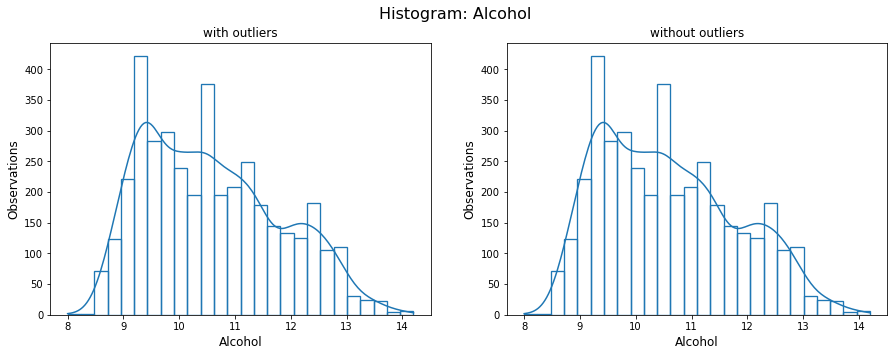

In [24]:
# histograms comparing alcohol with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogram: Alcohol', fontsize=16)

sns.histplot(ax=axes[0], data=white_wine, x="alcohol", kde=True, fill=False)
axes[0].set_xlabel('Alcohol', fontsize=12)
axes[0].set_ylabel('Observations', fontsize=12)
axes[0].set_title('with outliers')

sns.histplot(ax=axes[1], data=white_wine_trimmed_iqr, x="alcohol", kde=True, fill=False)
axes[1].set_xlabel('Alcohol', fontsize=12)
axes[1].set_ylabel('Observations', fontsize=12)
axes[1].set_title('without outliers')

I also view the distribution of the dependent variable - quality. The histogram and value_counts() show that most wines are rated as either a 5, 6, or 7. The highest rating (9) is least common, followed by the lowest rating (3). Because the ratings of the wines in this dataset are concentrated in the middle three ratings, it may be difficult for a model to determine what qualities determine a very good, or very bad wine.

<AxesSubplot:xlabel='quality', ylabel='Count'>

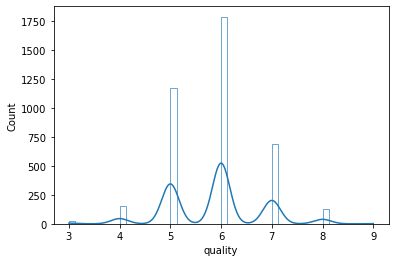

In [25]:
# histogram showing quality
sns.histplot(data=white_wine, x="quality", kde=True, fill=False)
#set_xlabel('Quality', fontsize=12)
#set_ylabel('Observations', fontsize=12)
#set_title('Quality')

In [26]:
white_wine['quality'].value_counts()

6    1788
5    1175
7     689
4     153
8     131
3      20
9       5
Name: quality, dtype: int64

## Explore relationships between variables

Examining a correlation matrix reveals that the correlations between the dependent variable (quality) and the independent variables are generally low. The strongest correlation is with 'alcohol' at 0.46, followed by density at -0.34. The matrix shows that alcohol and density have a strong correlation (-0.76).

In [27]:
# create correlation matrix
corr = white_wine.corr()

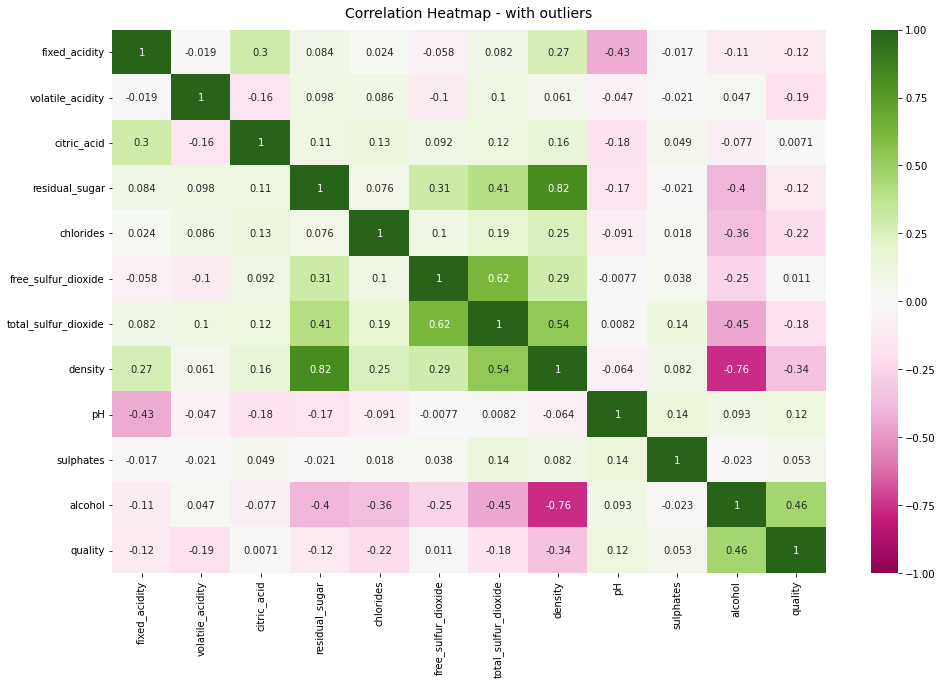

In [28]:
# create heatmap
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1,cmap="PiYG", annot=True)
heatmap.set_title('Correlation Heatmap - with outliers', fontdict={'fontsize':14}, pad=12);

# top correlations with quality - alcohol, sulphates, pH, free sulfur dioxide

The correlations of the variables after outliers are removed are similar to the correlations in the original dataset. The variable with the largest shift in correlation to quality is chlorides. The correlation between chlorides and quality shifted from -0.22 to 0.31 after outliers were removed.

In [29]:
# create correlation matrix for trimmed variables
corr_trimmed_iqr = white_wine_trimmed_iqr.corr()

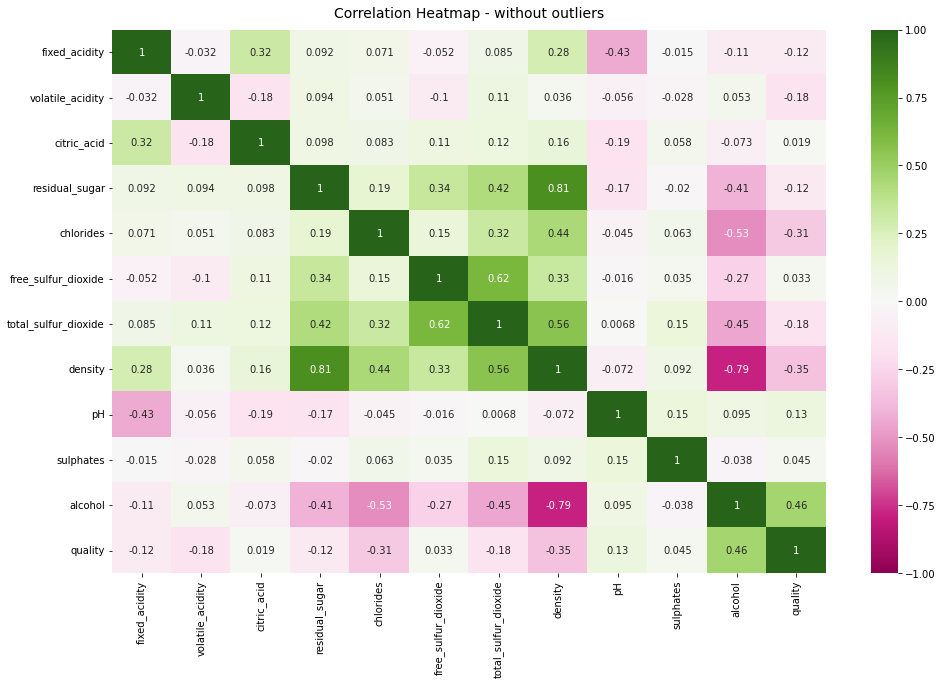

In [30]:
# create heatmap for trimmed variables
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(corr_trimmed_iqr, vmin=-1, vmax=1,cmap="PiYG", annot=True)
heatmap.set_title('Correlation Heatmap - without outliers', fontdict={'fontsize':14}, pad=12);

In [31]:
# define function to get top pairwise correlations
# function adapted from from stackoverflow: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

def get_redundant_pairs(white_wine):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = white_wine.columns
    for i in range(0, white_wine.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_correlations(df):
    au_corr = white_wine.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

In [32]:
# call function using white_wine
correlations = get_correlations(white_wine)

In [33]:
# view top correlations
correlations.head(10)

residual_sugar        density                 0.820498
density               alcohol                 0.760162
free_sulfur_dioxide   total_sulfur_dioxide    0.619437
total_sulfur_dioxide  density                 0.536868
alcohol               quality                 0.462869
total_sulfur_dioxide  alcohol                 0.446643
fixed_acidity         pH                      0.431274
residual_sugar        total_sulfur_dioxide    0.409583
                      alcohol                 0.398167
chlorides             alcohol                 0.356928
dtype: float64

Next, I analyzed the relationship between each independent variable and the dependent variable (quality), by examining boxplots that show the distribution of the independent variable for each possible classification of quality.

**Quality and Fixed Acidity** <br>
After outliers are removed, a slight negative relationship between fixed acidity and quality is evident in the boxplots - with the exception of an uptick in fixed acidity for the highest quality wines. The slight negative relationship seen in the boxplot matches the calculated correlation between the two variables (-0.12).
<br><br> 
We know that only 5 wines in our dataset have a quality score of 9, which is likely too small of a sample size to allow us to draw conclusions about which independent variables contirbute to the high score.

Text(0.5, 1.0, 'without outliers')

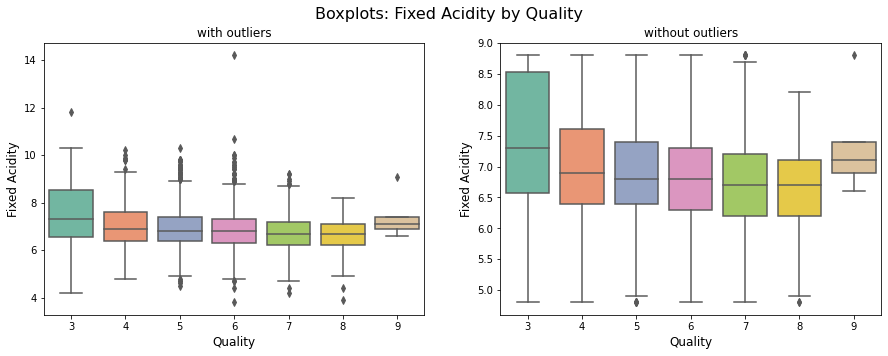

In [144]:
# boxplots comparing fixed acidity by quality with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots: Fixed Acidity by Quality', fontsize=16)

sns.boxplot(ax=axes[0], x="quality", y="fixed_acidity", data=white_wine, palette="Set2")
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Fixed Acidity', fontsize=12)
axes[0].set_title('with outliers')

sns.boxplot(ax=axes[1], x="quality", y="fixed_acidity", data=white_wine_trimmed_iqr, palette="Set2")
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Fixed Acidity', fontsize=12)
axes[1].set_title('without outliers')

**Quality and Volatile Acidity** <br>
It is difficult to identify a relationship between quality and volatile acidity by looking at the boxplots. However, the correlation coefficient is negative (-0.18).

Text(0.5, 1.0, 'without outliers')

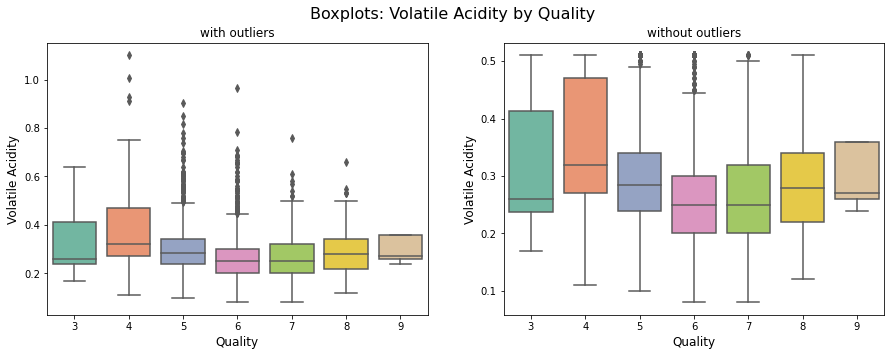

In [142]:
# boxplots comparing volatile acidity by quality with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots: Volatile Acidity by Quality', fontsize=16)

sns.boxplot(ax=axes[0], x="quality", y="volatile_acidity", data=white_wine, palette="Set2")
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Volatile Acidity', fontsize=12)
axes[0].set_title('with outliers')

sns.boxplot(ax=axes[1], x="quality", y="volatile_acidity", data=white_wine_trimmed_iqr, palette="Set2")
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Volatile Acidity', fontsize=12)
axes[1].set_title('without outliers')

**Quality and Citric Acid** <br>
There doesn't appear to be a relationship between citric acid and quality - the mean citric acid is relatively flat across wines with a quality score of 4 through 8. However, the correlation coefficient confirms this pattern (0.019).

Text(0.5, 1.0, 'without outliers')

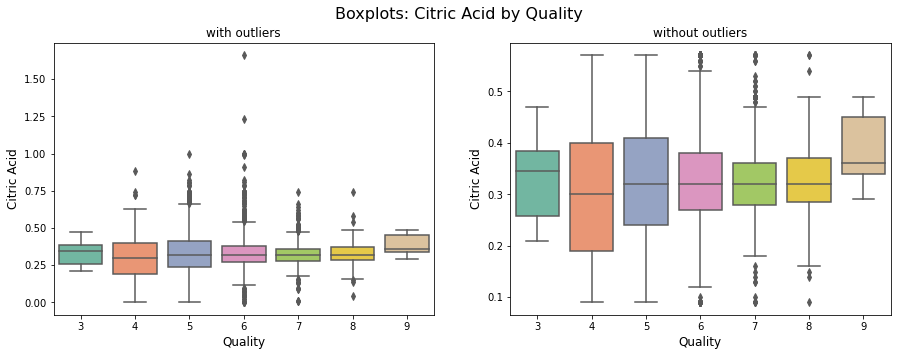

In [141]:
# boxplots comparing citric acid by quality with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots: Citric Acid by Quality', fontsize=16)

sns.boxplot(ax=axes[0], x="quality", y="citric_acid", data=white_wine, palette="Set2")
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Citric Acid', fontsize=12)
axes[0].set_title('with outliers')

sns.boxplot(ax=axes[1], x="quality", y="citric_acid", data=white_wine_trimmed_iqr, palette="Set2")
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Citric Acid', fontsize=12)
axes[1].set_title('without outliers')

**Quality and Residual Sugar** <br>
It is difficult to identify a relationship between quality and residual sugar by looking at the boxplots. The correlation coefficient is negative (-0.12).

Text(0.5, 1.0, 'without outliers')

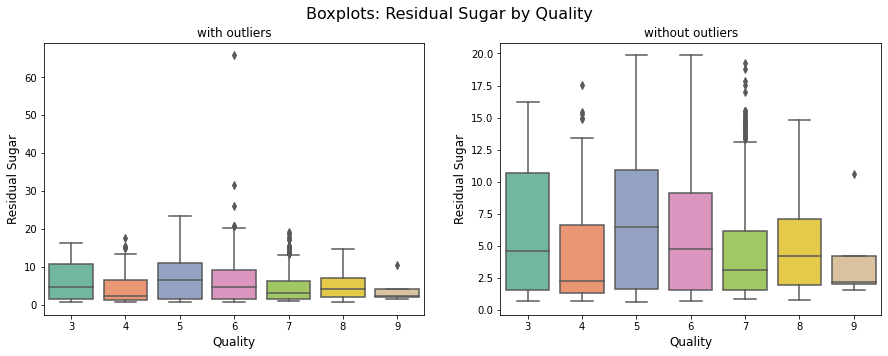

In [140]:
# boxplots comparing residual sugar by quality with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots: Residual Sugar by Quality', fontsize=16)

sns.boxplot(ax=axes[0], x="quality", y="residual_sugar", data=white_wine, palette="Set2")
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Residual Sugar', fontsize=12)
axes[0].set_title('with outliers')

sns.boxplot(ax=axes[1], x="quality", y="residual_sugar", data=white_wine_trimmed_iqr, palette="Set2")
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Residual Sugar', fontsize=12)
axes[1].set_title('without outliers')

**Quality and Chlorides** <br>
There appears to be a negative relationship between chlorides and quality. The correlation coefficient confirms this relationship (-0.31).

Text(0.5, 1.0, 'without outliers')

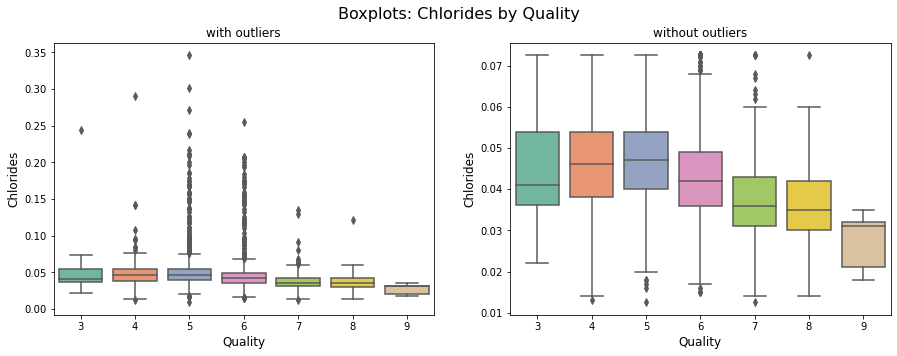

In [139]:
# boxplots comparing chlorides by quality with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots: Chlorides by Quality', fontsize=16)

sns.boxplot(ax=axes[0], x="quality", y="chlorides", data=white_wine, palette="Set2")
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Chlorides', fontsize=12)
axes[0].set_title('with outliers')

sns.boxplot(ax=axes[1], x="quality", y="chlorides", data=white_wine_trimmed_iqr, palette="Set2")
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Chlorides', fontsize=12)
axes[1].set_title('without outliers')

**Quality and Free Sulfur Dioxide** <br>
There does not appear to be a relationship between free sulfur dioxide and quality. The mean value for free sulfur dioxide across each quality score is very similar - with the exception of wines with a quality score of four. The correlation coefficient (0.033) confirms the trend identified by the visual.

Text(0.5, 1.0, 'without outliers')

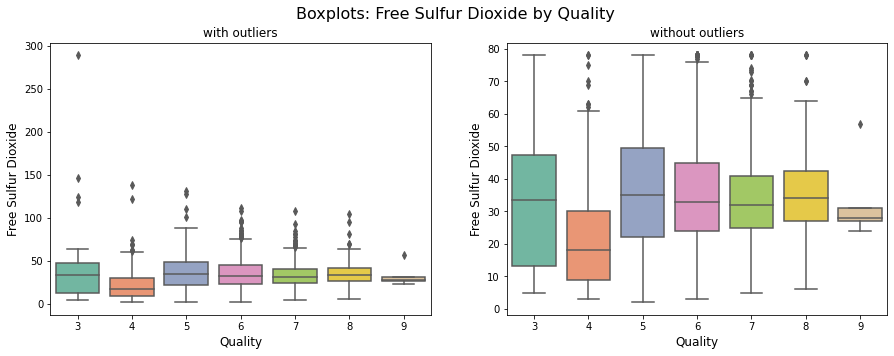

In [138]:
# boxplots comparing free sulfur dioxide by quality with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots: Free Sulfur Dioxide by Quality', fontsize=16)

sns.boxplot(ax=axes[0], x="quality", y="free_sulfur_dioxide", data=white_wine, palette="Set2")
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Free Sulfur Dioxide', fontsize=12)
axes[0].set_title('with outliers')

sns.boxplot(ax=axes[1], x="quality", y="free_sulfur_dioxide", data=white_wine_trimmed_iqr, palette="Set2")
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Free Sulfur Dioxide', fontsize=12)
axes[1].set_title('without outliers')

**Quality and Total Sulfur Dioxide** <br>
There appears to be a slight negative relationship between total sulfur dioxide and wine quality. The correlation coefficient is -0.18.

Text(0.5, 1.0, 'without outliers')

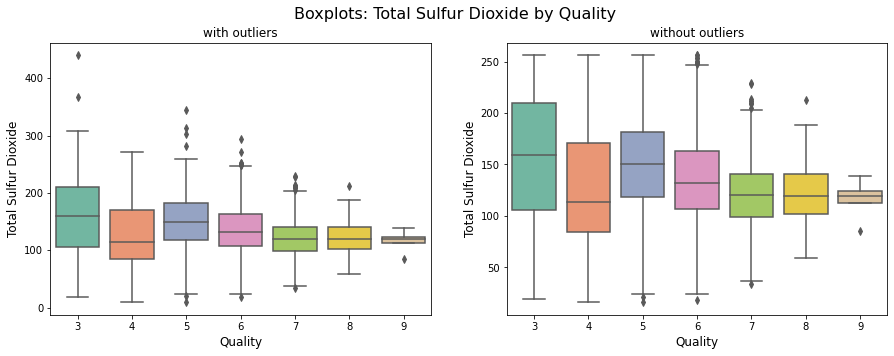

In [137]:
# boxplots comparing total sulfur dioxide by quality with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots: Total Sulfur Dioxide by Quality', fontsize=16)

sns.boxplot(ax=axes[0], x="quality", y="total_sulfur_dioxide", data=white_wine, palette="Set2")
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Total Sulfur Dioxide', fontsize=12)
axes[0].set_title('with outliers')

sns.boxplot(ax=axes[1], x="quality", y="total_sulfur_dioxide", data=white_wine_trimmed_iqr, palette="Set2")
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Total Sulfur Dioxide', fontsize=12)
axes[1].set_title('without outliers')

**Quality and Density** <br>
There appears to be a negative relationship between density and wine quality. The correlation coefficient (-0.35) confirms this trend.

Text(0.5, 1.0, 'without outliers')

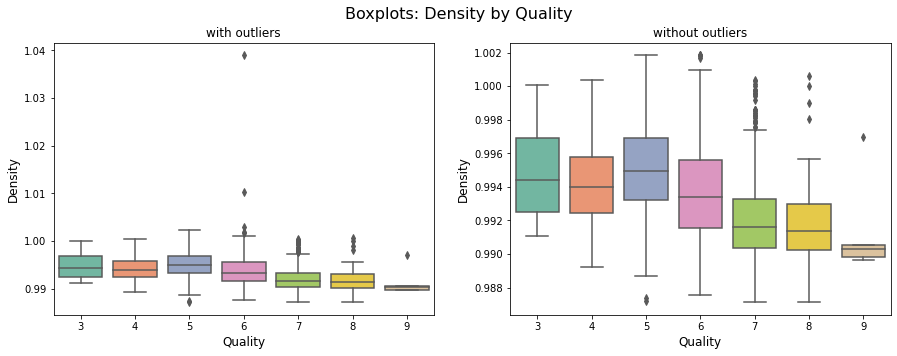

In [136]:
# boxplots comparing density by quality with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots: Density by Quality', fontsize=16)

sns.boxplot(ax=axes[0], x="quality", y="density", data=white_wine, palette="Set2")
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('with outliers')

sns.boxplot(ax=axes[1], x="quality", y="density", data=white_wine_trimmed_iqr, palette="Set2")
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('without outliers')

**Quality and pH** <br>
There appears to be a positive relationship between pH and wine quality. The correlation coefficient (0.13) confirms this trend.

Text(0.5, 1.0, 'without outliers')

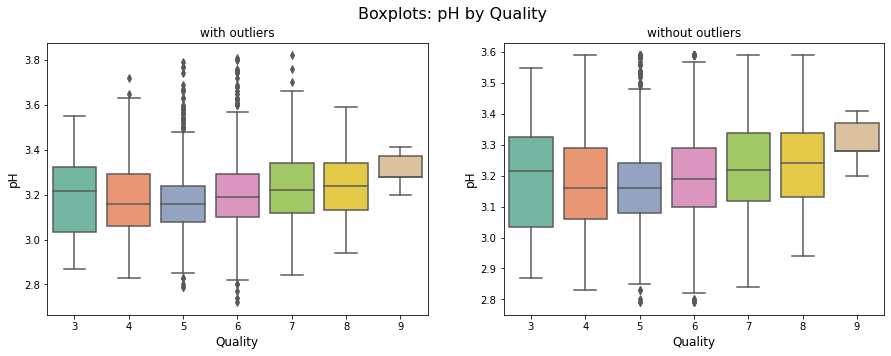

In [145]:
# boxplots comparing pH by quality with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots: pH by Quality', fontsize=16)

sns.boxplot(ax=axes[0], x="quality", y="pH", data=white_wine, palette="Set2")
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('pH', fontsize=12)
axes[0].set_title('with outliers')

sns.boxplot(ax=axes[1], x="quality", y="pH", data=white_wine_trimmed_iqr, palette="Set2")
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('pH', fontsize=12)
axes[1].set_title('without outliers')

**Quality and Sulphates** <br>
There does not appear to be a relationship between sulphates and wine quality. The correlation coefficient (0.045) confirms this trend.

Text(0.5, 1.0, 'without outliers')

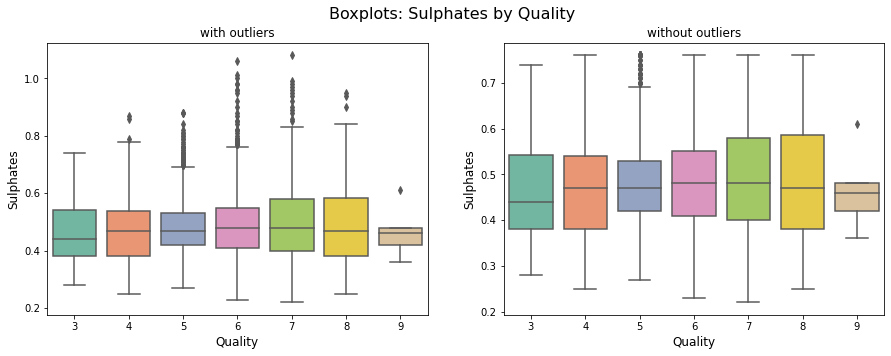

In [146]:
# boxplots comparing sulphates by quality with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots: Sulphates by Quality', fontsize=16)

sns.boxplot(ax=axes[0], x="quality", y="sulphates", data=white_wine, palette="Set2")
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Sulphates', fontsize=12)
axes[0].set_title('with outliers')

sns.boxplot(ax=axes[1], x="quality", y="sulphates", data=white_wine_trimmed_iqr, palette="Set2")
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Sulphates', fontsize=12)
axes[1].set_title('without outliers')

**Alcohol and Quality** <br>
The relationship between alcohol and wine quality might not be linear - the boxplots follow a parabolic pattern. However, it's important to remember that the sample size for wines with a quality of 3 or 4 is low (20 and 153, respectively). The correlation between these two variables is relatively strong (0.45).

Text(0.5, 1.0, 'without outliers')

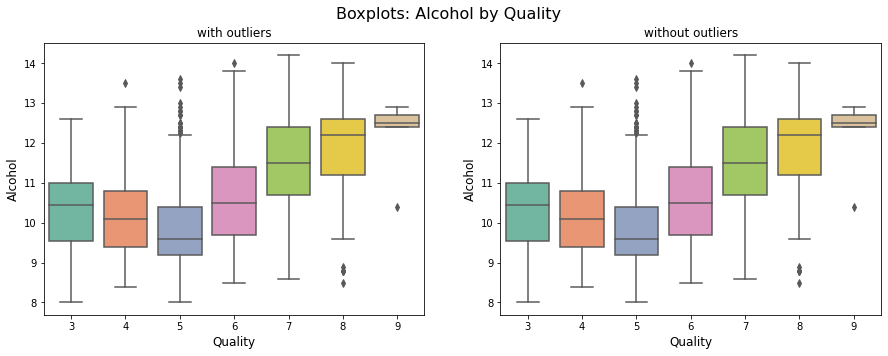

In [147]:
# boxplots comparing alcohol by quality with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots: Alcohol by Quality', fontsize=16)

sns.boxplot(ax=axes[0], x="quality", y="alcohol", data=white_wine, palette="Set2")
axes[0].set_xlabel('Quality', fontsize=12)
axes[0].set_ylabel('Alcohol', fontsize=12)
axes[0].set_title('with outliers')

sns.boxplot(ax=axes[1], x="quality", y="alcohol", data=white_wine_trimmed_iqr, palette="Set2")
axes[1].set_xlabel('Quality', fontsize=12)
axes[1].set_ylabel('Alcohol', fontsize=12)
axes[1].set_title('without outliers')

# Linear Regression Model

First, I tested two single-variate linear regression models (Model A and Model B) using the variables that have the highest correlation with quality - alcohol and chlorides. The Model A has stronger results.<br><br>
Then, I tested several mutli-variate linear regression models. 
- Model C uses three variables with relatively strong correlations with quality - density, chlorides, alcohol - as indepdendent variables. The model has an R2 of 0.226, which is slightly higher than the R2 of Model A (indepdent variable = alcohol).
- Model D uses the eight indepedent variables with the highest correlation with quality (fixed_acidity, volatile_acidity, residual_sugar, chlorides, total_sulfur_dioxide, density, pH, alcohol). The R2 value of Model D is 0.304.
- Model E uses all possible independent variables (fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol). The R2 value of Model E is 0.326.

## Model A (single variable)

### Split dataset into training and test set

In [195]:
# independent variable
x = white_wine_trimmed_iqr[['alcohol']]

# depedent variable
y = white_wine_trimmed_iqr[['quality']]

In [196]:
# split data into 80% training set and 20% testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)

In [197]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3168, 1)
(793, 1)
(3168, 1)
(793, 1)


### Create Linear Regression Model

In [198]:
# reshape X
x = x.values.reshape(-1, 1)

In [199]:
# create linear regression model
regr = linear_model.LinearRegression()

# fit model
regr.fit(x_train,y_train)

# predict y values
y_predict = regr.predict(x_test)

### Visualize results

Text(0.5, 1.0, 'Alcohol v. Quality')

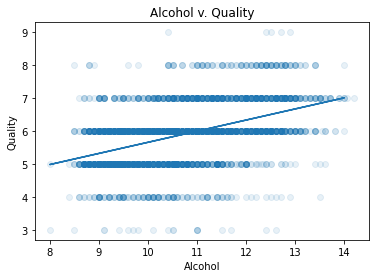

In [200]:
plt.clf()
plt.scatter(x,y,alpha=0.1)
plt.plot(x_test, y_predict)
plt.xlabel("Alcohol")
plt.ylabel("Quality")
plt.title("Alcohol v. Quality")

Text(0.5, 1.0, 'Quality - actual v. predicted')

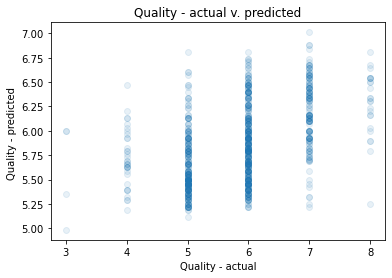

In [201]:
plt.clf()
plt.scatter(y_test,y_predict,alpha=0.1)
plt.xlabel("Quality - actual")
plt.ylabel("Quality - predicted ")
plt.title("Quality - actual v. predicted")

### Evaluate accuracy of model

- MSE is low, which indicates a better model. MSE is sensitive to outliers, which were removed during the EDA process.
- MAE is low, which indicates a better model. MAE is not sensitive to outliers. The fact that outliers were removed during the EDA process might help explain why MAE and MSE are very similar.
- R2 is low, which indicates a less successful model. An R2 of 0.211 indicates that the independent variables (in this case - alcohol), explains 21.1% of the variance in quality.

In [202]:
# find mean absolute error
mae = metrics.mean_absolute_error(y_test, y_predict)

# find mean squared error
mse = metrics.mean_squared_error(y_test, y_predict)

# find r2
r2 = metrics.r2_score(y_test, y_predict)

# find adjusted r2
adj_r2 = 1 - ( 1 - r2 ) * ( len(y_test) - 1 ) / ( len(y_test) - x.shape[1] - 1 )

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(round(mae,3)))
print('MSE is {}'.format(round(mse,3)))
print('R2 score is {}'.format(round(r2,3)))
print('Adj. R2 score is {}'.format(round(adj_r2,3)))

The model performance for testing set
--------------------------------------
MAE is 0.628
MSE is 0.625
R2 score is 0.211
Adj. R2 score is 0.21


## Model B (single variable)

### Split dataset into training and test set

In [203]:
# independent variable
x = white_wine_trimmed_iqr[['chlorides']]

# depedent variable
y = white_wine_trimmed_iqr[['quality']]

In [204]:
# split data into 80% training set and 20% testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)

In [205]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3168, 1)
(793, 1)
(3168, 1)
(793, 1)


### Create Linear Regression Model

In [206]:
# reshape X
x = x.values.reshape(-1, 1)

In [207]:
# create linear regression model
regr = linear_model.LinearRegression()

# fit model
regr.fit(x_train,y_train)

# predict y values
y_predict = regr.predict(x_test)

### Visualize results

Text(0.5, 1.0, 'Chlorides v. Quality')

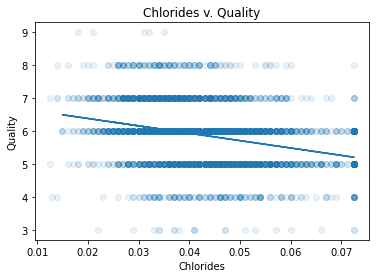

In [208]:
plt.clf()
plt.scatter(x,y,alpha=0.1)
plt.plot(x_test, y_predict)
plt.xlabel("Chlorides")
plt.ylabel("Quality")
plt.title("Chlorides v. Quality")

Text(0.5, 1.0, 'Quality - actual v. predicted')

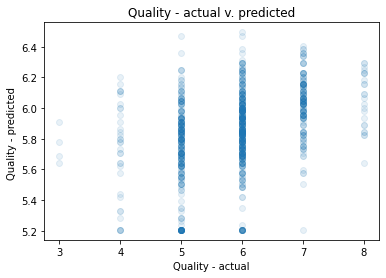

In [209]:
plt.clf()
plt.scatter(y_test,y_predict,alpha=0.1)
plt.xlabel("Quality - actual")
plt.ylabel("Quality - predicted ")
plt.title("Quality - actual v. predicted")

### Evaluate accuracy of model

- MSE is low, which indicates a better model. MSE is sensitive to outliers, which were removed during the EDA process.
- MAE is low, which indicates a better model. MAE is not sensitive to outliers. The fact that outliers were removed during the EDA process might help explain why MAE and MSE are very similar.
- R2 is low, which indicates a less successful model. An R2 of 0.137 indicates that the independent variables (in this case - chlorides), explains 13.7% of the variance in quality.

In [210]:
# find mean absolute error
mae = metrics.mean_absolute_error(y_test, y_predict)

# find mean squared error
mse = metrics.mean_squared_error(y_test, y_predict)

# find r2
r2 = metrics.r2_score(y_test, y_predict)

# find adjusted r2
adj_r2 = 1 - ( 1 - r2 ) * ( len(y_test) - 1 ) / ( len(y_test) - x.shape[1] - 1 )

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(round(mae,3)))
print('MSE is {}'.format(round(mse,3)))
print('R2 score is {}'.format(round(r2,3)))
print('Adj. R2 score is {}'.format(round(adj_r2,3)))

The model performance for testing set
--------------------------------------
MAE is 0.637
MSE is 0.684
R2 score is 0.137
Adj. R2 score is 0.136


## Model C (multi-variate)

### Split dataset into training and test set

In [211]:
# independent variable
x = white_wine_trimmed_iqr[['chlorides',
                'density',
                'alcohol']]

# depedent variable
y = white_wine_trimmed_iqr[['quality']]

In [212]:
# split data into 80% training set and 20% testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)

In [213]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3168, 3)
(793, 3)
(3168, 1)
(793, 1)


### Create Linear Regression Model

In [214]:
# create linear regression model
regr = linear_model.LinearRegression()

# fit model
regr.fit(x_train,y_train)

# predict y values
y_predict = regr.predict(x_test)

In [215]:
# save coefficients
coef = regr.coef_

print(coef)

[[-5.28635789 14.64050302  0.33826415]]


In [216]:
# view mlr coefficients as table

# create df with indepdendent variables in first column, corresponding coefficients in second column
coef_df = pd.concat([pd.DataFrame(x.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)

# rename columns
coef_df = coef_df.set_axis(['ind_var','coef'], axis=1, inplace=False)

In [217]:
# display coef_df
coef_df

,ind_var,coef
0,chlorides,-5.286358
1,density,14.640503
2,alcohol,0.338264


### Compare model results to actual results

Text(0.5, 1.0, 'actual quality v. predicted quality')

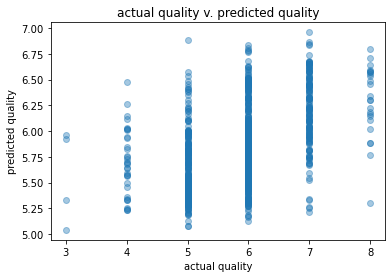

In [218]:
plt.clf()
plt.scatter(y_test,y_predict,alpha=0.4)
plt.xlabel("actual quality")
plt.ylabel("predicted quality")
plt.title("actual quality v. predicted quality")

### Evaluate accuracy of the model

- MSE is low, which indicates a better model. MSE is sensitive to outliers, which were removed during the EDA process.
- MAE is low, which indicates a better model. MAE is not sensitive to outliers. The fact that outliers were removed during the EDA process might help explain why MAE and MSE are very similar.
- R2 is low, which indicates a less successful model. An R2 of 0.226 indicates that the independent variables (in this case - density, chlorides, alcohol) collectively explains 22.6% of the variance in quality.

In [219]:
# find mean absolute error
mae = metrics.mean_absolute_error(y_test, y_predict)

# find mean squared error
mse = metrics.mean_squared_error(y_test, y_predict)

# find r2
r2 = metrics.r2_score(y_test, y_predict)

# find adjusted r2
adj_r2 = 1 - ( 1 - r2 ) * ( len(y_test) - 1 ) / ( len(y_test) - x.shape[1] - 1 )

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(round(mae,3)))
print('MSE is {}'.format(round(mse,3)))
print('R2 score is {}'.format(round(r2,3)))
print('Adj. R2 score is {}'.format(round(adj_r2,3)))

The model performance for testing set
--------------------------------------
MAE is 0.62
MSE is 0.613
R2 score is 0.226
Adj. R2 score is 0.223


## Model D (multi-variate)

### Split dataset into training and test set

In [220]:
# independent variable
x = white_wine_trimmed_iqr[['fixed_acidity',
                'volatile_acidity',
                'residual_sugar',
                'chlorides',
                'total_sulfur_dioxide',
                'density',
                'pH',
                'alcohol']]

# depedent variable
y = white_wine_trimmed_iqr[['quality']]

In [221]:
# split data into 80% training set and 20% testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)

In [222]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3168, 8)
(793, 8)
(3168, 1)
(793, 1)


### Create Linear Regression Model

In [223]:
# create linear regression model
regr = linear_model.LinearRegression()

# fit model
regr.fit(x_train,y_train)

# predict y values
y_predict = regr.predict(x_test)

In [224]:
# save coefficients
coef = regr.coef_

print(coef)

[[ 1.04833518e-01 -2.05465502e+00  8.73763525e-02 -1.16820204e+00
   1.68555218e-03 -1.91299932e+02  1.00639598e+00  1.53866052e-01]]


In [225]:
# view mlr coefficients as table

# create df with indepdendent variables in first column, corresponding coefficients in second column
coef_df = pd.concat([pd.DataFrame(x.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)

# rename columns
coef_df = coef_df.set_axis(['ind_var','coef'], axis=1, inplace=False)

In [226]:
# display coef_df
coef_df

,ind_var,coef
0,fixed_acidity,0.104834
1,volatile_acidity,-2.054655
2,residual_sugar,0.087376
3,chlorides,-1.168202
4,total_sulfur_dioxide,0.001686
5,density,-191.299932
6,pH,1.006396
7,alcohol,0.153866


### Compare model results to actual results

In [227]:
# define characteristics
#player_a = [[42, 66]]
#predict = regr.predict(player_a)
#print('Predicted winnings %.2f' % predict)
#print('Actual winnings: $201,163')

Text(0.5, 1.0, 'actual quality v. predicted quality')

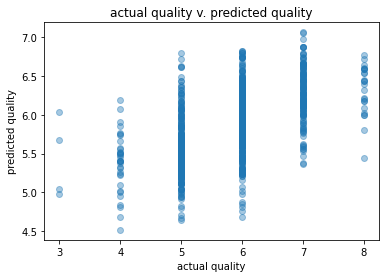

In [228]:
plt.clf()
plt.scatter(y_test,y_predict,alpha=0.4)
plt.xlabel("actual quality")
plt.ylabel("predicted quality")
plt.title("actual quality v. predicted quality")

### Evaluate accuracy of the model

- MSE is low, which indicates a better model. MSE is sensitive to outliers, which were removed during the EDA process.
- MAE is low, which indicates a better model. MAE is not sensitive to outliers. The fact that outliers were removed during the EDA process might help explain why MAE and MSE are very similar.
- R2 is low, which indicates a less successful model. An R2 of 0.326 indicates that the independent variables (in this case - fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, and alcohol) collectively explains 32.6% of the variance in quality.

In [229]:
# find mean absolute error
mae = metrics.mean_absolute_error(y_test, y_predict)

# find mean squared error
mse = metrics.mean_squared_error(y_test, y_predict)

# find r2
r2 = metrics.r2_score(y_test, y_predict)

# find adjusted r2
adj_r2 = 1 - ( 1 - r2 ) * ( len(y_test) - 1 ) / ( len(y_test) - x.shape[1] - 1 )

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(round(mae,3)))
print('MSE is {}'.format(round(mse,3)))
print('R2 score is {}'.format(round(r2,3)))
print('Adj. R2 score is {}'.format(round(adj_r2,3)))

The model performance for testing set
--------------------------------------
MAE is 0.581
MSE is 0.551
R2 score is 0.304
Adj. R2 score is 0.297


## Model E (multi-variate)

### Split dataset into training and test set

In [230]:
# independent variable
x = white_wine_trimmed_iqr[['fixed_acidity',
                'volatile_acidity',
                'citric_acid',
                'residual_sugar',
                'chlorides',
                'free_sulfur_dioxide',
                'total_sulfur_dioxide',
                'density',
                'pH',
                'sulphates',
                'alcohol']]

# depedent variable
y = white_wine_trimmed_iqr[['quality']]

In [231]:
# split data into 80% training set and 20% testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)

In [232]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3168, 11)
(793, 11)
(3168, 1)
(793, 1)


### Create Linear Regression Model

In [233]:
# create linear regression model
regr = linear_model.LinearRegression()

# fit model
regr.fit(x_train,y_train)

# predict y values
y_predict = regr.predict(x_test)

In [234]:
# save coefficients
coef = regr.coef_

print(coef)

[[ 1.32445281e-01 -1.69553495e+00  2.96108257e-01  9.43879133e-02
  -9.12845624e-01  6.88985192e-03 -3.60439149e-04 -2.16805690e+02
   1.09218591e+00  7.89527773e-01  1.16079422e-01]]


In [235]:
# view mlr coefficients as table

# create df with indepdendent variables in first column, corresponding coefficients in second column
coef_df = pd.concat([pd.DataFrame(x.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)

# rename columns
coef_df = coef_df.set_axis(['ind_var','coef'], axis=1, inplace=False)

In [236]:
# display coef_df
coef_df

,ind_var,coef
0,fixed_acidity,0.132445
1,volatile_acidity,-1.695535
2,citric_acid,0.296108
3,residual_sugar,0.094388
4,chlorides,-0.912846
5,free_sulfur_dioxide,0.006890
6,total_sulfur_dioxide,-0.000360
7,density,-216.805690
8,pH,1.092186
9,sulphates,0.789528


### Compare model results to actual results

Text(0.5, 1.0, 'actual quality v. predicted quality')

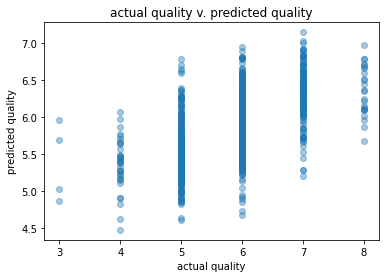

In [237]:
plt.clf()
plt.scatter(y_test,y_predict,alpha=0.4)
plt.xlabel("actual quality")
plt.ylabel("predicted quality")
plt.title("actual quality v. predicted quality")

### Evaluate accuracy of the model

- MSE is low, which indicates a better model. MSE is sensitive to outliers, which were removed during the EDA process.
- MAE is low, which indicates a better model. MAE is not sensitive to outliers. The fact that outliers were removed during the EDA process might help explain why MAE and MSE are very similar.
- R2 is low, which indicates a less successful model. An R2 of 0.326 indicates that the independent variables (in this case - fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, and alcohol) collectively explains 32.6% of the variance in quality.

In [238]:
# find mean absolute error
mae = metrics.mean_absolute_error(y_test, y_predict)

# find mean squared error
mse = metrics.mean_squared_error(y_test, y_predict)

# find r2
r2 = metrics.r2_score(y_test, y_predict)

# find adjusted r2
adj_r2 = 1 - ( 1 - r2 ) * ( len(y_test) - 1 ) / ( len(y_test) - x.shape[1] - 1 )

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(round(mae,3)))
print('MSE is {}'.format(round(mse,3)))
print('R2 score is {}'.format(round(r2,3)))
print('Adj. R2 score is {}'.format(round(adj_r2,3)))

The model performance for testing set
--------------------------------------
MAE is 0.572
MSE is 0.533
R2 score is 0.326
Adj. R2 score is 0.317


In [194]:
# define characteristics
#player_a = [[42, 66]]
#predict = regr.predict(player_a)
#print('Predicted winnings %.2f' % predict)
#print('Actual winnings: $201,163')